# Relax take-home challenge
Predicting whether a user is going to be an adopted user.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas_profiling as pdprofiling

Read in user data.

In [3]:
users_df = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding = 'latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Read in engagement data.

In [4]:
engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'], encoding = 'utf-8')
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


Almost no fields seem to have any null values at first glance.

Let's take a closer look at the users dataframe with Pandas Profiling.

In [6]:
pdprofiling.ProfileReport(users_df)

Number of variables,10
Number of observations,12000
Total Missing (%),7.3%
Total size in memory,937.6 KiB
Average record size in memory,80.0 B
Numeric,4
Categorical,3
Boolean,2
Date,1
Text (Unique),0
Rejected,0


## Findings from user table

1. There are quite a few zeros in the 'org_id' column, which means that zero is either a code for an organization with large presence on Relax platform,  or this is a code for all users who are not associated with an org.
1. There are 20 duplicates in email addresses.
1. There may be duplicates in the names (there's also a possibility some folks have the same, popular, name, e.g. Jessica Smith).
1. object_id, which uniquely identifies each user, does not have any duplicates, however.

Let's dig deeper into the duplicate email addresses, as those are the most obvious candidates for deleting as true duplicates.

In [7]:
duplicate_emails = users_df[users_df.duplicated(subset=['email'], keep=False)].sort_values(by = ['email'])

Maybe there are duplicates in the dataframe that are only unique in their 'object_id'?

In [8]:
users_df[users_df.duplicated(subset= np.array(users_df.columns)[1:], keep=False)].sort_values(by = ['email'])

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id


There are no glaring duplicates in the users table. We can come back to it to figure out what to do with duplicate emails, once we take a look at the engagement table.

In [9]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
pdprofiling.ProfileReport(engagement_df)

Number of variables,3
Number of observations,207917
Total Missing (%),0.0%
Total size in memory,4.8 MiB
Average record size in memory,24.0 B
Numeric,1
Categorical,0
Boolean,0
Date,1
Text (Unique),0
Rejected,1


## Findings from the engagement file
1. We only have 8,823 users that were in some way engaged with Relax during the period we are considering. This is out of about 12,000 users listed in the user file, which is about 74% of all registered users.
2. About 4% of users engaged with the product only once.

## Determining which users are adopted

Now let's determine which of the users mentioned in the engagement file are adopted and which are not. A user is considered adopted if they accessed the product on at least three separate days in a seven day period

In [11]:
engagement_df.sort_values(by = 'time_stamp', inplace = True)

Build a dataframe that shows whether or not a user accessed Relax on a particular day: users_each_day

In [12]:
users_each_day = engagement_df.groupby('user_id').resample('d', on = 'time_stamp').sum().fillna(0)
users_each_day.head()

user_id  visited
user_id time_stamp                  
1       2014-04-22        1        1
2       2013-11-15        2        1
        2013-11-16        0        0
        2013-11-17        0        0
        2013-11-18        0        0

In [13]:
users_each_day.drop(['user_id'], axis = 1, inplace = True)

Let's check what sort of values we are dealing with in 'visited'.

In [14]:
users_each_day['visited'].value_counts()

0    314584
1    207917
Name: visited, dtype: int64

Build a dataframe showing the number of separate days each user visited Relax in each rolling 7 day period: visits_per_7_day_interval.

In [15]:
visits_per_7_day_interval = users_each_day.reset_index().groupby('user_id')['visited'].rolling(7, min_periods=1).sum().reset_index()
visits_per_7_day_interval.head()

,user_id,level_1,visited
0,1,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


In [16]:
visits_per_7_day_interval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522501 entries, 0 to 522500
Data columns (total 3 columns):
user_id    522501 non-null int64
level_1    522501 non-null int64
visited    522501 non-null float64
dtypes: float64(1), int64(2)
memory usage: 12.0 MB


Compute a series of all adopted users: adopted_users.

In [17]:
adopted_users = visits_per_7_day_interval[visits_per_7_day_interval['visited']>=3]['user_id'].drop_duplicates()
len(adopted_users)

1602

## Wrangling the users dataset
Let's simply remove all duplicate emails, only keeping entries that list their earliest registration date and time.

In [18]:
users_no_dups_early_reg = users_df.sort_values(by = 'creation_time').drop_duplicates(['email'], keep = 'first')
users_no_dups_early_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 3860 to 6052
Data columns (total 10 columns):
object_id                     11980 non-null int64
creation_time                 11980 non-null datetime64[ns]
name                          11980 non-null object
email                         11980 non-null object
creation_source               11980 non-null object
last_session_creation_time    8807 non-null float64
opted_in_to_mailing_list      11980 non-null int64
enabled_for_marketing_drip    11980 non-null int64
org_id                        11980 non-null int64
invited_by_user_id            6407 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 1.0+ MB


Which orgs have the most users?

In [19]:
users_no_dups_early_reg.groupby('org_id').count()['object_id'].head(5)

org_id
0    318
1    233
2    200
3    168
4    159
Name: object_id, dtype: int64

Organizations seem to be numbered by the number of users that registered for them. If we are to assume that that is how  they will be encoded in the future, that is an excellent property. Usually organizations that have a lot of active users, already have the ecosystem that will keep the users active.

Let's one-hot encode 'creation_source'.

In [20]:
users_for_model = pd.concat([users_no_dups_early_reg, pd.get_dummies(users_no_dups_early_reg['creation_source'], drop_first=True)], axis=1)
users_for_model

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
3860,3861,2012-05-31 00:43:27,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,1.338684e+09,0,0,115,3861.0,1,0,0,0
11429,11430,2012-05-31 01:42:31,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,1.338515e+09,0,0,239,5677.0,1,0,0,0
7169,7170,2012-05-31 06:23:51,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,1.345444e+09,0,0,145,7170.0,1,0,0,0
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,1,0,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,1,0,0
1994,1995,2012-05-31 13:14:18,Cardoso Rafaela,RafaelaAzevedoCardoso@hotmail.com,ORG_INVITE,1.338556e+09,1,0,363,1995.0,1,0,0,0
10162,10163,2012-05-31 14:30:38,Olesen Alexander,AlexanderLOlesen@gustr.com,PERSONAL_PROJECTS,1.338561e+09,0,0,282,NaN,0,1,0,0
10627,10628,2012-05-31 15:20:16,Romero Susan,idtlvyip@dvseo.com,ORG_INVITE,1.338737e+09,0,0,82,10639.0,1,0,0,0
10815,10816,2012-05-31 15:41:54,Johnson Laura,LauraCJohnson@yahoo.com,SIGNUP,1.339084e+09,1,1,371,NaN,0,0,1,0
3427,3428,2012-05-31 15:47:36,Spears Arthur,ArthurJSpears@gmail.com,SIGNUP_GOOGLE_AUTH,1.352822e+09,1,0,166,NaN,0,0,0,1


Create a feature that would just show if a user was invited or not: 'is_invited'. We will fill NaN values with zeros in one swoop at the end of feature engineering.

In [21]:
users_for_model.loc[users_for_model['invited_by_user_id'].notnull(), 'is_invited'] = 1 
users_for_model.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,is_invited
3860,3861,2012-05-31 00:43:27,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,1.338684e+09,0,0,115,3861.0,1,0,0,0,1.0
11429,11430,2012-05-31 01:42:31,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,1.338515e+09,0,0,239,5677.0,1,0,0,0,1.0
7169,7170,2012-05-31 06:23:51,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,1.345444e+09,0,0,145,7170.0,1,0,0,0,1.0
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,1,0,0,0,1.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0,1,0,0,NaN


Convert last session creation time into a datetime.

In [22]:
users_for_model['last_session_creation_time'] = pd.to_datetime(users_for_model['last_session_creation_time'], unit = 's')
users_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 3860 to 6052
Data columns (total 15 columns):
object_id                     11980 non-null int64
creation_time                 11980 non-null datetime64[ns]
name                          11980 non-null object
email                         11980 non-null object
creation_source               11980 non-null object
last_session_creation_time    8807 non-null datetime64[ns]
opted_in_to_mailing_list      11980 non-null int64
enabled_for_marketing_drip    11980 non-null int64
org_id                        11980 non-null int64
invited_by_user_id            6407 non-null float64
ORG_INVITE                    11980 non-null uint8
PERSONAL_PROJECTS             11980 non-null uint8
SIGNUP                        11980 non-null uint8
SIGNUP_GOOGLE_AUTH            11980 non-null uint8
is_invited                    6407 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(4), object(3), uint8(4)
memory usage: 1.1+ MB


In [23]:
import datetime as dt

Compute number of days between account creation and last session: 'last_seen_v_created'

In [24]:
users_for_model['last_seen_v_created'] = (users_for_model['last_session_creation_time'] - users_for_model['creation_time']).astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
users_for_model.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,is_invited,last_seen_v_created
3860,3861,2012-05-31 00:43:27,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,2012-06-03 00:43:27,0,0,115,3861.0,1,0,0,0,1.0,3.0
11429,11430,2012-05-31 01:42:31,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,2012-06-01 01:42:31,0,0,239,5677.0,1,0,0,0,1.0,1.0
7169,7170,2012-05-31 06:23:51,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,2012-08-20 06:23:51,0,0,145,7170.0,1,0,0,0,1.0,81.0
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,2012-05-31 08:20:06,0,1,225,7104.0,1,0,0,0,1.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,0,1,0,0,NaN,2.0


In [25]:
users_for_model.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH',
       'is_invited', 'last_seen_v_created'],
      dtype='object')

In [26]:
users_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 3860 to 6052
Data columns (total 16 columns):
object_id                     11980 non-null int64
creation_time                 11980 non-null datetime64[ns]
name                          11980 non-null object
email                         11980 non-null object
creation_source               11980 non-null object
last_session_creation_time    8807 non-null datetime64[ns]
opted_in_to_mailing_list      11980 non-null int64
enabled_for_marketing_drip    11980 non-null int64
org_id                        11980 non-null int64
invited_by_user_id            6407 non-null float64
ORG_INVITE                    11980 non-null uint8
PERSONAL_PROJECTS             11980 non-null uint8
SIGNUP                        11980 non-null uint8
SIGNUP_GOOGLE_AUTH            11980 non-null uint8
is_invited                    6407 non-null float64
last_seen_v_created           8807 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4), o

Select features, and fill null values with zeros: the columns affected with fillna() will only be 'is_invited' and 'last_seen_v_created'. <br>Note that we are keeping 'creation_time' to later be able to split data into train and test sets, with users that we use for training having created their accounts before those we test on.

In [27]:
users_for_model_binary = users_for_model[['object_id', 'creation_time',  'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP',
       'SIGNUP_GOOGLE_AUTH', 'is_invited', 'last_seen_v_created']].fillna(0)

Add target variable to the dataset. 

In [28]:
users_for_model_binary['adopted_user'] = users_for_model_binary['object_id'].isin(adopted_users).astype(int)
users_for_model_binary.head()

,object_id,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,is_invited,last_seen_v_created,adopted_user
3860,3861,2012-05-31 00:43:27,0,0,115,1,0,0,0,1.0,3.0,0
11429,11430,2012-05-31 01:42:31,0,0,239,1,0,0,0,1.0,1.0,0
7169,7170,2012-05-31 06:23:51,0,0,145,1,0,0,0,1.0,81.0,0
10011,10012,2012-05-31 08:20:06,0,1,225,1,0,0,0,1.0,0.0,0
11998,11999,2012-05-31 11:55:59,0,0,6,0,1,0,0,0.0,2.0,0


The data we are dealing with are not balanced.

In [29]:
users_for_model_binary.adopted_user.value_counts()

0    10380
1     1600
Name: adopted_user, dtype: int64

We are missing two of adopted users in our table (based on earlier calculations, we had 1,602 adopted users in the dataset, but due to data cleaning we lost two).

Define predictors and target variable.

In [30]:
X = users_for_model_binary.sort_values(by = 'creation_time').drop(['object_id', 'creation_time', 'adopted_user'], axis = 1)
y = users_for_model_binary['adopted_user']

We'll use about 80% of the dataset for training, and the rest for testing.

In [31]:
train_size = len(y)*4//5
train_size

9584

In [32]:
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

We will use XGBoost classifier to do the prediction, because it tends to perform well in classifications on datasets with large numbers of observations. <br>
For this to work, we will need to compute the balancing factor from our test data, since our data is not balanced.

In [33]:
neg_to_pos = test_y.value_counts()[0]/test_y.value_counts()[1]

In [41]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

clf = XGBClassifier(scale_pos_weight=neg_to_pos)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Accuracy (Test) : 0.9165
AUC Score (Test): 0.921938
Precision (Test): 0.916528
[[2067  190]
 [  10  129]]


The model is performing quite well. Now let's see feature importances.

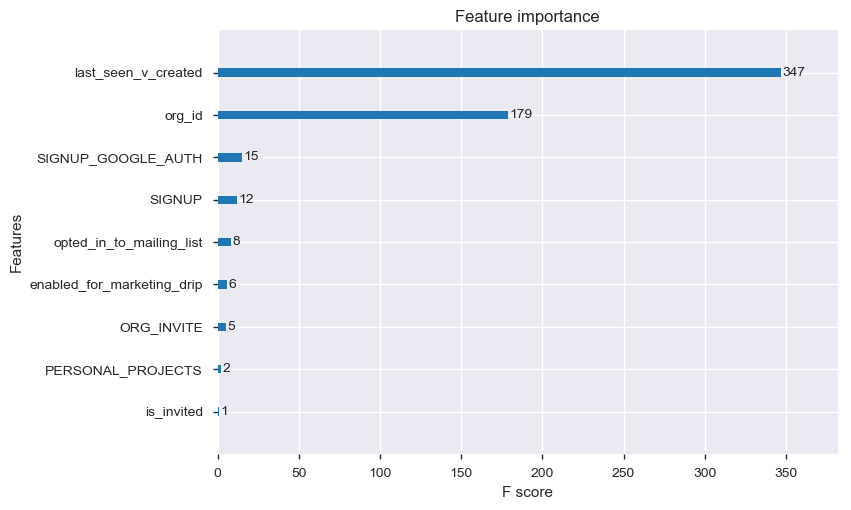

In [42]:
import xgboost
xgboost.plot_importance(clf, ax=None, height=0.2, xlim=None, ylim=None, \
                             title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', \
                             max_num_features=None, grid=True, show_values=True)
plt.show()

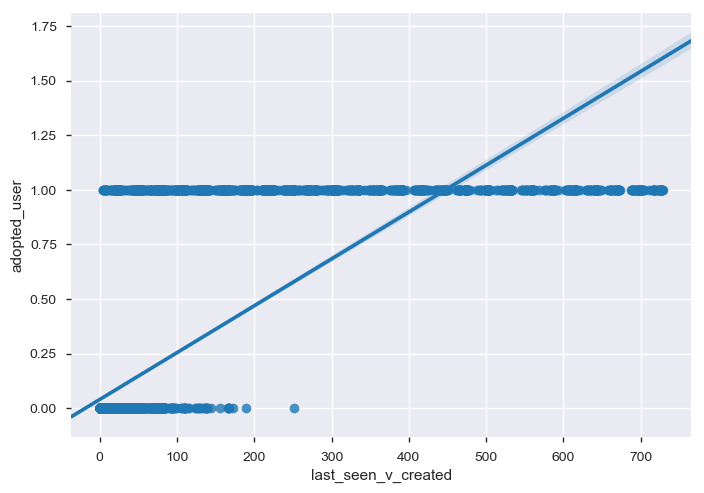

In [43]:
import seaborn as sns
sns.regplot(y=users_for_model_binary['adopted_user'], x=users_for_model_binary['last_seen_v_created'], fit_reg = True)
plt.show()

The longer the time between the date user was last seen and their account creation date, the more likely they are to be adopted. This variable is problematic, because it has a significant survivorship bias.

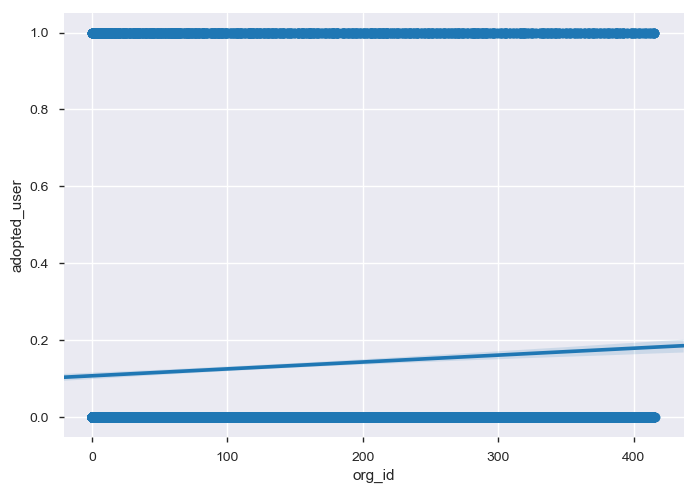

In [45]:
sns.regplot(y=users_for_model_binary['adopted_user'], x=users_for_model_binary['org_id'], fit_reg = True)
plt.show()

This makes sense: the higher the number of users in an organization, the more likely they it is that they are active/adopted.

# Conclusion
How long the user has been a customer is important, as well as their 'org_id' (in this case, it also means how many registered users their organization has), next one is 'creation_source'. Interestingly enough, whether or not the user was invited by their organization, or by another user does not make a difference.

However, as mentioned before, there is survival bias: the longer you are a user, the longer time you had the opportunity to have 3 active days in one 7 day period.<br>
What if we excluded feature 'last_seen_v_created' from the model?

In [39]:
train_X2 = train_X.drop(['last_seen_v_created'], axis = 1)
test_X2 = test_X.drop(['last_seen_v_created'], axis = 1)

clf = XGBClassifier(scale_pos_weight=neg_to_pos)
clf.fit(train_X2, train_y)
pred_y = clf.predict(test_X2)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Accuracy (Test) : 0.1114
AUC Score (Test): 0.521605
Precision (Test): 0.111436
[[ 130 2127]
 [   2  137]]


C:\Users\Dinara\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Unsurprisingly, the model performs much, much worse without the feature 'last_seen_v_created'. 

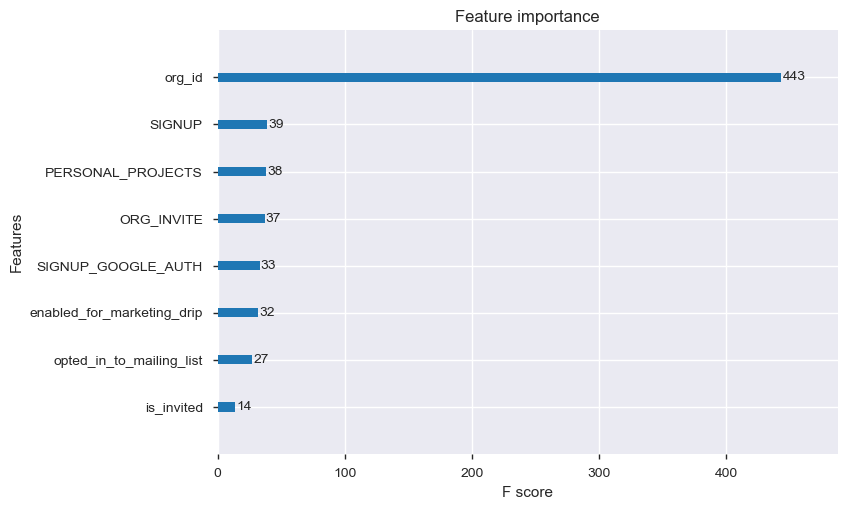

In [40]:
xgboost.plot_importance(clf, ax=None, height=0.2, xlim=None, ylim=None, \
                             title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', \
                             max_num_features=None, grid=True, show_values=True)
plt.show()

Feature importances follow the same order we saw in the previous model.

<b>Ideas for further research:</b>

1. We could feature-engineer the following features, and incorporate them into our data as predictors: 
    - Is the user who invited current user, adopted?
    - What's the proportion of adopted users to all users in the organization that the user belongs to?
    - Was the user invited by someone in the same organization?

2. I would redefine 'adopted' user as someone who used the product for three days in a seven day period, <i>within the last 6 months</i>. This definition will entail less survivorship bias, as only recent activity is taken into account. An example why this may be a good idea: what if a user only ever used the product three days in a row after signing up years ago, and never used it again? Why do we call that user adopted? - They abandoned the product long time ago.